In [12]:
import lib.experimentize as E
from autosklearn.classification import AutoSklearnClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

from src.feature_selector import FeatureSelector, FEATURE_SELECTION_METHODS
from src.dataset_loader import DatasetLoader, DATASETS

class Params(E.ParamsBase):
    time_limit = 30
    dataset = DATASETS[0]
    method = FEATURE_SELECTION_METHODS[0]
    max_features = 1000
    seed = 1

@E.experimentize(Params)
class Experiment(FeatureSelector, DatasetLoader):
    def auto_classifier(self, *, time_limit=E.param, seed=E.param):
        return AutoSklearnClassifier(
            time_left_for_this_task=time_limit,
            include = {
                'feature_preprocessor': ["no_preprocessing"]
            },
            seed=seed
        )
    
    def run(self, *, method=E.param(as_func="feature_selection_{}")):
        train_x, test_x, train_y, test_y = self.train_test_split()
        selector = method(train_x, train_y)
        train_x, test_x = selector(train_x), selector(test_x)

        automl = self.auto_classifier()
        automl.fit(train_x, train_y)
        return {
            "Accuracy": metrics.accuracy_score(test_y, automl.predict(test_x)),
            "Features": train_x.shape[1]
        }


In [13]:
grid = [
    Params(method=method, dataset=dataset, max_features=max_features, seed=seed)
    for method in FEATURE_SELECTION_METHODS
    for dataset in DATASETS
    for max_features in [75]
    for seed in range(2)
]
results = Experiment().run(E.AsExperiment(grid, with_cache="cache/benchmark.pickle"))()
results

,iteration,method,dataset,max_features,seed,Accuracy,Features
0,0,Random Forest,artificial,75,0,0.8350,75
1,0,Random Forest,artificial,75,1,0.8300,75
2,0,ANOVA,artificial,75,0,0.7800,75
3,0,ANOVA,artificial,75,1,0.7675,75
4,0,Mutual Info,artificial,75,0,0.7150,75
5,0,Mutual Info,artificial,75,1,0.7075,75


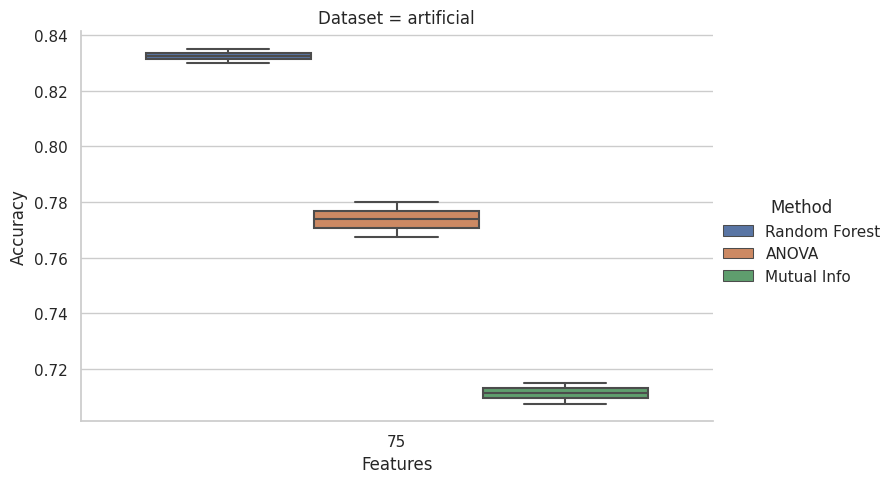

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=results.prettify(), kind="box",
    x="Features", y="Accuracy", hue="Method", col="Dataset",
    height=5, aspect=1.5
)
plt.show()